Import Libraries and Load Calibration Data

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- Configuration ---
# Path to the saved calibration data file
CALIBRATION_FILE = 'calibration_data.npz'
# Path to a sample distorted image (use one of your calibration images or another image from the same camera)
# Make sure this image exists!
TEST_IMAGE_PATH = 'calibration_images/left01.jpg' # ADJUST THIS PATH if needed

# --- Load Calibration Data ---
if not os.path.exists(CALIBRATION_FILE):
    print(f"Error: Calibration file '{CALIBRATION_FILE}' not found.")
    print("Please run the 'calibrate_camera.py' script first.")
    # Stop execution if the file is missing in a notebook context
    raise FileNotFoundError(f"Calibration file '{CALIBRATION_FILE}' not found.")
else:
    print(f"Loading calibration data from '{CALIBRATION_FILE}'...")
    calibration_data = np.load(CALIBRATION_FILE)
    mtx = calibration_data['mtx']
    dist = calibration_data['dist']
    new_camera_mtx = calibration_data['new_camera_mtx']
    roi = calibration_data['roi']
    map1 = calibration_data['map1']
    map2 = calibration_data['map2']
    img_size = tuple(calibration_data['img_size']) # Convert back to tuple if needed

    print("Calibration data loaded successfully.")
    print("Image size used for calibration:", img_size)
    # print("Camera Matrix (K):\n", mtx)
    # print("Distortion Coefficients:\n", dist)
    # print("New Camera Matrix:\n", new_camera_mtx)
    # print("ROI:\n", roi)

Loading calibration data from 'calibration_data.npz'...
Calibration data loaded successfully.
Image size used for calibration: (np.int64(640), np.int64(480))


Load the Test Image

In [3]:
# --- Load a Distorted Test Image ---
if not os.path.exists(TEST_IMAGE_PATH):
    print(f"Error: Test image '{TEST_IMAGE_PATH}' not found. Please check the path.")
    # Stop execution if the file is missing
    raise FileNotFoundError(f"Test image '{TEST_IMAGE_PATH}' not found.")
else:
    img_distorted = cv2.imread(TEST_IMAGE_PATH)
    if img_distorted is None:
         print(f"Error: Failed to load test image '{TEST_IMAGE_PATH}'.")
         raise IOError(f"Failed to load test image '{TEST_IMAGE_PATH}'.")
    else:
        # Ensure the test image size matches the calibration image size
        h, w = img_distorted.shape[:2]
        if (w, h) != img_size:
             print(f"Warning: Test image size {(w, h)} differs from calibration size {img_size}. Resizing...")
             img_distorted = cv2.resize(img_distorted, img_size)

        img_distorted_rgb = cv2.cvtColor(img_distorted, cv2.COLOR_BGR2RGB) # For matplotlib display
        print(f"Test image '{TEST_IMAGE_PATH}' loaded.")

Test image 'calibration_images/left01.jpg' loaded.


Apply Undistortion using remap

In [4]:
# --- Apply Undistortion using the generated maps ---
# cv2.remap is efficient because the maps are pre-calculated.
# INTER_LINEAR provides good quality for most cases.
img_undistorted = cv2.remap(img_distorted, map1, map2, cv2.INTER_LINEAR)

# Optional: Crop the image using the ROI
# The ROI tells us the region in the undistorted image that contains valid pixels.
x, y, w, h = roi
img_undistorted_cropped = img_undistorted[y:y+h, x:x+w]

img_undistorted_rgb = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB)
img_undistorted_cropped_rgb = cv2.cvtColor(img_undistorted_cropped, cv2.COLOR_BGR2RGB)


print("Undistortion applied.")
if w > 0 and h > 0:
    print("Cropped to Region of Interest (ROI).")
else:
    print("ROI is empty, skipping crop display (might happen if alpha=1 and no cropping needed).")

Undistortion applied.
Cropped to Region of Interest (ROI).


Visualize Before and After

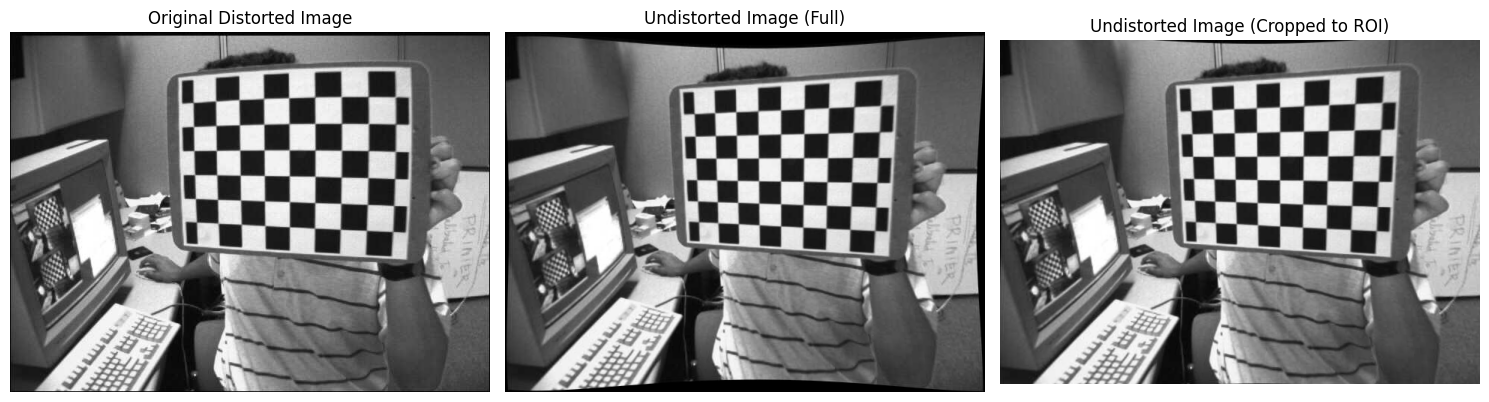

In [5]:
# --- Visualize Results ---
plt.figure(figsize=(15, 10))

# Original Distorted Image
plt.subplot(1, 3, 1)
plt.imshow(img_distorted_rgb)
plt.title('Original Distorted Image')
plt.axis('off')

# Undistorted Image (Full)
plt.subplot(1, 3, 2)
plt.imshow(img_undistorted_rgb)
plt.title('Undistorted Image (Full)')
plt.axis('off')

# Undistorted Image (Cropped to ROI)
if w > 0 and h > 0:
    plt.subplot(1, 3, 3)
    plt.imshow(img_undistorted_cropped_rgb)
    plt.title('Undistorted Image (Cropped to ROI)')
    plt.axis('off')
else:
    # If ROI is empty, just show the full undistorted image again or add text
     plt.subplot(1, 3, 3)
     plt.text(0.5, 0.5, 'No Cropping Applied\n(ROI likely covers full image)',
              horizontalalignment='center', verticalalignment='center', fontsize=12)
     plt.title('Undistorted Image (Cropped)')
     plt.axis('off')


plt.tight_layout()
plt.show()

# You can also save the undistorted image
# cv2.imwrite('undistorted_image.jpg', img_undistorted)
# cv2.imwrite('undistorted_cropped_image.jpg', img_undistorted_cropped)

Compare Pixel Error (Discussion)

In [ ]:
# --- Comparing Pixel Error ---

# 1. Visual Inspection:
#    The most common way for this exercise is visual. Look at the 'Undistorted Image'.
#    - Do straight lines in the real-world scene (like the edges of the chessboard)
#      now appear straight in the image? They should, especially near the borders.
#    - Barrel distortion (bulging outwards) or pincushion distortion (pinching inwards)
#      should be visibly corrected.

# 2. Reprojection Error (Calculated during Calibration):
#    The 'mean reprojection error' calculated in the calibration script (`calibrate_camera.py`)
#    is the standard quantitative measure. It tells us, on average, how far (in pixels)
#    the projected 3D chessboard corners (using the calculated mtx, dist, rvecs, tvecs)
#    are from the corners detected in the original images.
#    A low value (e.g., < 0.5 pixels) indicates a good calibration and thus effective undistortion.
#    We already printed this value when running the calibration script.

# 3. Undistorting Specific Points (Advanced):
#    If you had detected specific points (like corners) in the *distorted* test image,
#    you could undistort *just those points* using `cv2.undistortPoints`.
#    Then, you could compare their undistorted positions to their known ideal positions
#    (e.g., if using a chessboard, compare to the ideal grid coordinates).
#    This gives a direct measure of distortion correction at those specific locations.

# Example for point undistortion (requires points detected in the distorted image):
# distorted_points = np.array([...], dtype=np.float32).reshape(-1, 1, 2) # Needs actual detected points
# if 'distorted_points' in locals() and distorted_points.size > 0:
#     undistorted_points = cv2.undistortPoints(distorted_points, mtx, dist, P=new_camera_mtx)
#     # Now you could compare 'undistorted_points' to expected ground truth locations.
#     print("\nSample Undistorted Points (if applicable):\n", undistorted_points)

print("\nPixel Error Comparison:")
print(" - Visually inspect the 'Original' vs 'Undistorted' images.")
print(" - Check if straight lines appear straight after undistortion.")
print(f" - Recall the Mean Reprojection Error from calibration (should be low, e.g., < 0.5 pixels).")